In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
EP6 = pd.read_csv("/content/drive/MyDrive/ Thesis 2023/EP6_total3.csv")

In [ ]:
import numpy as np

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/lsa_comps6th.pickle', 'rb') as f:
    lsa_comps = pickle.load(f)

In [ ]:
EP6["raw_text"].isna().sum() #quitar las instancias que no tienen texto


409

In [ ]:
EP6 = EP6.drop(["Unnamed: 0"],axis=1)


In [ ]:
print(EP6["Type of Vote"].isna().sum())
print(EP6["Policy_area"].isna().sum())
print(EP6["Title"].isna().sum())

5
0
0


In [ ]:
EP6  = EP6.dropna(subset=['raw_text'])
# Fill NaN values with empty strings
EP6.fillna('', inplace=True)


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.2 MB/s eta 0:00:00


In [ ]:
lsa_comps.shape

(844, 21)

In [ ]:

lsa_comps = lsa_comps.astype(np.int64)

In [ ]:
EP6.shape

(844, 945)

In [ ]:
column_types = EP6.dtypes
print(column_types)

Vote ID          int64
raw_text        object
Type of Vote    object
Policy_area     object
Title           object
                 ...  
95280            int64
95281            int64
95704            int64
96101            int64
23852            int64
Length: 945, dtype: object


In [ ]:
EP6.columns

Index(['Vote ID', 'raw_text', 'Type of Vote', 'Policy_area', 'Title', '28469',
       '28302', '28975', '28367', '28512',
       ...
       '95017', '95019', '95014', '72754', '95298', '95280', '95281', '95704',
       '96101', '23852'],
      dtype='object', length=945)

# LOGISTIC REGRESSION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

f1_scores = []
roc_aucs = []
auprc_scores = []
recall_scores = []
precision_scores = []
predictions_list = []
true_labels_list = []
accuracy = []
shap_importances_dict = {}
X_test_dict = {}
accuracy_results = {}
counter = 1
newtruelist = []
newpredlist = []
roc_list = []

# Loop through each MEP column and train a separate model for each MEP
for col in EP6.columns[5:]:
    # Step 1: Prepare the data
    X = lsa_comps  # Input features (TF-IDF + truncated SVD features)
    y = EP6[col].values  # Target variable (voting behavior of the MEP)
    MEP_ID = col
    print(counter)
    counter += 1
    # Check the number of unique classes in the target variable
    num_classes = len(np.unique(y))
    if num_classes < 2:
        print(f"Skipping MEP {col} due to only one class present.")
        continue

    # Step 2: Split the data into training and testing sets
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ])
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)

    for train_index, test_index in cv.split(X_ros, y_ros):
        try:
            X_train, X_test = X_ros[train_index], X_ros[test_index]
            y_train, y_test = y_ros[train_index], y_ros[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))
            whichprediction = np.unique(y_test)
            newpredlist = np.concatenate([newpredlist, whichprediction[np.argmax(predictions, axis=1)]])
            newtruelist = np.concatenate([newtruelist, y_test])
            for item in predictions:
              roc_list.append(item)
        except IndexError:
            print("Index out of bounds. Skipping this iteration.")
            continue
    whichprediction = np.unique(y_test)
    # Calculate evaluation metrics
    try:
      f1 = f1_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    except IndexError:
      continue
    #f12 = f1_score(y_test, np.argmax(predictions, axis=1), average='weighted')
    #roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y)), predictions, multi_class='ovr')
    precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1], pos_label=1)
    auprc = auc(recall, precision)
    recall = recall_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    precision = precision_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    accuracy = accuracy_score(y_test, whichprediction[np.argmax(predictions, axis=1)])
    #accuracy_3 = accuracy_score(y_test,np.argmax(predictions, axis=1))

    max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
    predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
    predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
    true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
    roc_auc = roc_auc_score(label_binarize(true_labels_array, classes=np.unique(true_labels_array)), predictions_array, multi_class='ovr')
    # Store the metrics in corresponding lists
    f1_scores.append(f1)
    #f1_scores2.append(f12)
    roc_aucs.append(roc_auc)
    auprc_scores.append(auprc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    #accuracy2.append(accuracy_2)
    #accuracy3.append(accuracy_3)
    # Compute SHAP feature importances
    accuracy_results[col] = {'accuracy': accuracy}

    # Increment counter


# Convert the accuracy_results dictionary to a DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_results, orient='index')

# Add the MEP column to the DataFrame
accuracy_df = accuracy_df.reset_index().rename(columns={'index': 'MEP'})




In [ ]:
print("done")

done


In [ ]:
accuracy_df.describe()

,accuracy
count,939.000000
mean,0.336606
std,0.058454
min,0.212528
25%,0.296634
50%,0.327869
75%,0.364407
max,0.738019


In [ ]:
precision_scores_df = pd.DataFrame(precision_scores, columns=["precision"])

# Apply describe function to the data frames
precision_scores_stats = precision_scores_df.describe()


# Print the statistics
print("precision Statistics:")
print(precision_scores_stats)


precision Statistics:
        precision
count  939.000000
mean     0.353300
std      0.119425
min      0.092849
25%      0.264998
50%      0.349966
75%      0.427582
max      0.795403


In [ ]:
# Convert lists to data frames
f1_scores_df = pd.DataFrame(f1_scores, columns=['F1 Score'])
roc_aucs_df = pd.DataFrame(roc_aucs, columns=['ROC AUC'])
# Apply describe function to the data frames
f1_scores_stats = f1_scores_df.describe()
roc_aucs_stats = roc_aucs_df.describe()

# Print the statistics
print("F1 Score Statistics:")
print(f1_scores_stats)
print("\nROC AUC Statistics:")
print(roc_aucs_stats)

F1 Score Statistics:
         F1 Score
count  939.000000
mean     0.259198
std      0.061281
min      0.126120
25%      0.219356
50%      0.252446
75%      0.287714
max      0.721083

ROC AUC Statistics:
          ROC AUC
count  939.000000
mean     0.552813
std      0.007312
min      0.536913
25%      0.548801
50%      0.549552
75%      0.555685
max      0.639346


In [ ]:
auprc_scores_df = pd.DataFrame(auprc_scores, columns=["auprc"])
recall_scores_df = pd.DataFrame(recall_scores, columns=["recall"])


# Apply describe function to the data frames
auprc_scores_stats = auprc_scores_df.describe()
recall_stats = recall_scores_df.describe()
# Print the statistics
print("AUPRC Statistics:")
print(auprc_scores_stats)
print("recall Statistics:")
print(recall_stats)

AUPRC Statistics:
            auprc
count  939.000000
mean     0.281527
std      0.136256
min      0.127192
25%      0.175723
50%      0.223436
75%      0.350912
max      0.777909
recall Statistics:
           recall
count  939.000000
mean     0.336606
std      0.058454
min      0.212528
25%      0.296634
50%      0.327869
75%      0.364407
max      0.738019


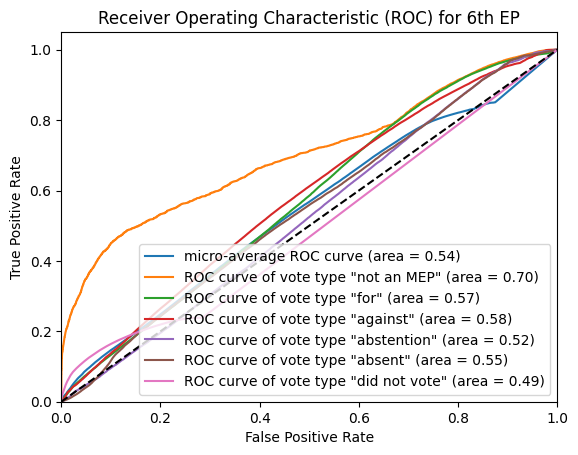

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
whichprediction = np.unique(y_test)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of vote type "{0}" (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for 6th EP')
plt.legend(loc="lower right")
plt.show()


# LINEAR SVM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
f1_scores = []
roc_aucs = []
auprc_scores = []
recall_scores = []
precision_scores = []
predictions_list = []
true_labels_list = []
accuracy = []
shap_importances_dict = {}
X_test_dict = {}
accuracy_results = {}
counter = 1
newtruelist = []
newpredlist = []
roc_list = []

# Loop through each MEP column and train a separate model for each MEP
for col in EP6.columns[5:]:
    # Step 1: Prepare the data
    X = lsa_comps  # Input features (TF-IDF + truncated SVD features)
    y = EP6[col].values  # Target variable (voting behavior of the MEP)
    MEP_ID = col
    print(counter)
    counter += 1
    # Check the number of unique classes in the target variable
    num_classes = len(np.unique(y))
    if num_classes < 2:
        print(f"Skipping MEP {col} due to only one class present.")
        continue

    # Step 2: Split the data into training and testing sets
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
    model = Pipeline([
        ('scaler', StandardScaler()),
       ('classifier', CalibratedClassifierCV(LinearSVC()))
    ])
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)

    for train_index, test_index in cv.split(X_ros, y_ros):
        try:
            X_train, X_test = X_ros[train_index], X_ros[test_index]
            y_train, y_test = y_ros[train_index], y_ros[test_index]

            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))
            whichprediction = np.unique(y_test)
            newpredlist = np.concatenate([newpredlist, whichprediction[np.argmax(predictions, axis=1)]])
            newtruelist = np.concatenate([newtruelist, y_test])
            for item in predictions:
              roc_list.append(item)
        except IndexError:
            print("Index out of bounds. Skipping this iteration.")
            continue
    whichprediction = np.unique(y_test)
    # Calculate evaluation metrics
    try:
      f1 = f1_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    except IndexError:
      continue
    #f12 = f1_score(y_test, np.argmax(predictions, axis=1), average='weighted')
    #roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y)), predictions, multi_class='ovr')
    precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1], pos_label=1)
    auprc = auc(recall, precision)
    recall = recall_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    precision = precision_score(y_test, whichprediction[np.argmax(predictions, axis=1)], average='weighted')
    accuracy = accuracy_score(y_test, whichprediction[np.argmax(predictions, axis=1)])
    #accuracy_3 = accuracy_score(y_test,np.argmax(predictions, axis=1))

    max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
    predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
    predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
    true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
    roc_auc = roc_auc_score(label_binarize(true_labels_array, classes=np.unique(true_labels_array)), predictions_array, multi_class='ovr')
    # Store the metrics in corresponding lists
    f1_scores.append(f1)
    #f1_scores2.append(f12)
    roc_aucs.append(roc_auc)
    auprc_scores.append(auprc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    #accuracy2.append(accuracy_2)
    #accuracy3.append(accuracy_3)
    # Compute SHAP feature importances
    accuracy_results[col] = {'accuracy': accuracy}

    # Increment counter


# Convert the accuracy_results dictionary to a DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_results, orient='index')

# Add the MEP column to the DataFrame
accuracy_df = accuracy_df.reset_index().rename(columns={'index': 'MEP'})




In [ ]:
print("done")

done


In [ ]:
accuracy_df.describe()

,accuracy
count,939.000000
mean,0.335534
std,0.058728
min,0.212528
25%,0.295873
50%,0.327824
75%,0.363152
max,0.738019


In [ ]:
precision_scores_df = pd.DataFrame(precision_scores, columns=["precision"])

# Apply describe function to the data frames
precision_scores_stats = precision_scores_df.describe()


# Print the statistics
print("precision Statistics:")
print(precision_scores_stats)


precision Statistics:
        precision
count  939.000000
mean     0.362251
std      0.122232
min      0.092849
25%      0.273771
50%      0.353601
75%      0.437234
max      0.795403


In [ ]:
# Convert lists to data frames
f1_scores_df = pd.DataFrame(f1_scores, columns=['F1 Score'])
roc_aucs_df = pd.DataFrame(roc_aucs, columns=['ROC AUC'])
# Apply describe function to the data frames
f1_scores_stats = f1_scores_df.describe()
roc_aucs_stats = roc_aucs_df.describe()

# Print the statistics
print("F1 Score Statistics:")
print(f1_scores_stats)
print("\nROC AUC Statistics:")
print(roc_aucs_stats)

F1 Score Statistics:
         F1 Score
count  939.000000
mean     0.258816
std      0.061247
min      0.126120
25%      0.219404
50%      0.252456
75%      0.287135
max      0.721083

ROC AUC Statistics:
          ROC AUC
count  939.000000
mean     0.552138
std      0.007782
min      0.534788
25%      0.547727
50%      0.548797
75%      0.554760
max      0.639935


In [ ]:
auprc_scores_df = pd.DataFrame(auprc_scores, columns=["auprc"])
recall_scores_df = pd.DataFrame(recall_scores, columns=["recall"])


# Apply describe function to the data frames
auprc_scores_stats = auprc_scores_df.describe()
recall_stats = recall_scores_df.describe()
# Print the statistics
print("AUPRC Statistics:")
print(auprc_scores_stats)
print("recall Statistics:")
print(recall_stats)

AUPRC Statistics:
            auprc
count  939.000000
mean     0.292902
std      0.136999
min      0.127192
25%      0.180596
50%      0.241547
75%      0.373288
max      0.777909
recall Statistics:
           recall
count  939.000000
mean     0.335534
std      0.058728
min      0.212528
25%      0.295873
50%      0.327824
75%      0.363152
max      0.738019


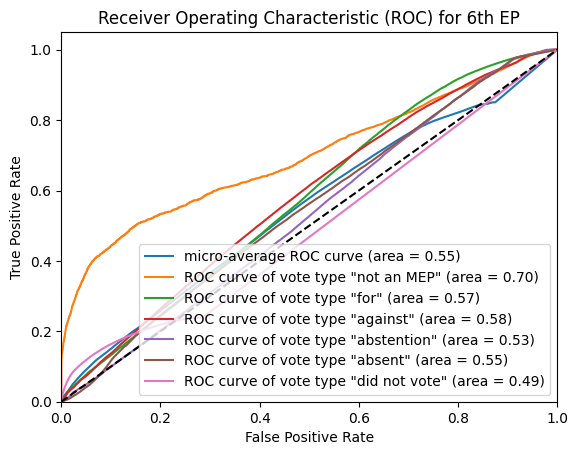

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
whichprediction = np.unique(y_test)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of vote type "{0}" (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for 6th EP')
plt.legend(loc="lower right")
plt.show()
